# How to Train Detectron2 on Custom Objects

This tutorial implements the new [Detectron2 Library](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) by facebook. This notebook shows training on **your own custom objects** for object detection.

It is worth noting that the Detectron2 library goes far beyond object detection, supporting semantic segmentation, keypoint detection, mask, and densepose.


### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train Detectron2](https://blog.roboflow.ai/how-to-train-detectron2/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train Detectron2 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install Detectron2 dependencies
* Download custom Detectron2 object detection data
* Visualize Detectron2 training data
* Write our Detectron2 Training configuration
* Run Detectron2 training
* Evaluate Detectron2 performance
* Run Detectron2 inference on test images



### **About**

[Roboflow](https://roboflow.ai) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Install Detectron2 Dependencies

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.5 (from versions: 1.7.1, 1.7.1+cu101, 1.8.0, 1.8.0+cu101, 1.8.1, 1.8.1+cu101, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=da5e2d57308bafab1ae3864a45482883d4f49e9adcc3ff0b2ecacd9cc844290b
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: py

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
ERROR: Could not find a version that satisfies the requirement detectron2==0.1.3 (from versions: none)
ERROR: No matching distribution found for detectron2==0.1.3


In [3]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-05c3aoq7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-05c3aoq7
  Resolved https://github.com/facebookresearch/detectron2.git to commit 072713649a9b0069c10aad1aaab819112e8f1e2e
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 144.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [5]:
!curl -L "https://universe.roboflow.com/ds/80Ej7HpyNL?key=Io9x2M7O4g" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   884  100   884    0     0   2099      0 --:--:-- --:--:-- --:--:--  2094
100 36.7M  100 36.7M    0     0  10.3M      0  0:00:03  0:00:03 --:--:-- 15.9M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/Barley_Yellow_Dwarf_153_jpg.rf.32e36870c3f7f7ede235eb962a15b83a.jpg  
 extracting: test/Barley_Yellow_Dwarf_169_jpg.rf.6f7002c52ec6449fae4352a8f5092316.jpg  
 extracting: test/Barley_Yellow_Dwarf_180_jpg.rf.2e7781e81dd54f0a11b3748e83177b58.jpg  
 extracting: test/Barley_Yellow_Dwarf_185_jpg.rf.b35871a1fd6fc35b1c1eeec4029ad429.jpg  
 extracting: test/Barley_Yellow_Dwarf_198_jpg.rf.e0ed0a05b6280c6960a9a8801096039c.jpg  
 extracting: test/Barley_Yellow_Dwarf_209_jpg.rf.fbf64a8d09f2ca7b89c7dd83b1892932.jpg  
 extracting: test/Barley_Yellow_Dwarf_

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train1", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val1", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test1", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [03/17 05:48:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/17 05:48:57 d2.data.datasets.coco]: Loaded 2603 images in COCO format from /content/train/_annotations.coco.json


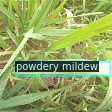

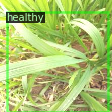

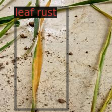

In [7]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train1")
dataset_dicts = DatasetCatalog.get("my_dataset_train1")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [8]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [9]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train1",)
cfg.DATASETS.TEST = ("my_dataset_val1",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 800
cfg.SOLVER.MAX_ITER = 1200 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (500, 1000)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/17 05:49:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:40, 10.4MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[03/17 05:49:49 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/17 05:50:24 d2.utils.events]:  eta: 0:27:57  iter: 19  total_loss: 2.48  loss_cls: 1.639  loss_box_reg: 0.6665  loss_rpn_cls: 0.09466  loss_rpn_loc: 0.01969    time: 1.3939  last_time: 1.1623  data_time: 0.0184  last_data_time: 0.0155   lr: 2.1638e-06  max_mem: 4214M
[03/17 05:50:54 d2.utils.events]:  eta: 0:28:43  iter: 39  total_loss: 2.408  loss_cls: 1.59  loss_box_reg: 0.6996  loss_rpn_cls: 0.05435  loss_rpn_loc: 0.01586    time: 1.4409  last_time: 1.4052  data_time: 0.0144  last_data_time: 0.0196   lr: 3.3888e-06  max_mem: 4214M
[03/17 05:51:25 d2.utils.events]:  eta: 0:29:05  iter: 59  total_loss: 2.359  loss_cls: 1.481  loss_box_reg: 0.722  loss_rpn_cls: 0.071  loss_rpn_loc: 0.01566    time: 1.4763  last_time: 1.5400  data_time: 0.0095  last_data_time: 0.0067   lr: 4.6137e-06  max_mem: 4214M
[03/17 05:51:53 d2.utils.events]:  eta: 0:28:07  iter: 79  total_loss: 2.077  loss_cls: 1.33  loss_box_reg: 0.6865  loss_rpn_cls: 0.03584  loss_rpn_loc: 0.01203    time: 1.4661  last_tim

In [10]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [11]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test1")
inference_on_dataset(trainer.model, val_loader, evaluator)

[03/17 06:21:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [03/17 06:21:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [03/17 06:21:31 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/17 06:21:31 d2.data.datasets.coco]: Loaded 99 images in COCO format from /content/test/_annotations.coco.json
[03/17 06:21:31 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |   category    | #instances   |  category  | #instances   |
|:----------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
|  diseases  | 0            | barley yell.. | 0            |  healthy   | 36           |
| leaf rust  | 84           | powdery mil.. | 22           |            |              |
|   total    | 142   

OrderedDict([('bbox',
              {'AP': 9.227178408252124,
               'AP50': 21.866486920063082,
               'AP75': 9.311146355477296,
               'APs': 0.0,
               'APm': 1.0432827633693704,
               'APl': 17.45438878548499,
               'AP-diseases': nan,
               'AP-barley yellow dwarf': nan,
               'AP-healthy': 19.110780221533236,
               'AP-leaf rust': 3.678637439827988,
               'AP-powdery mildew': 4.892117563395146})])

# Inference with Detectron2 Saved Weights



In [12]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [13]:
if os.name == "nt":
    import _locale
    _locale._gdl_bak = _locale._getdefaultlocale
    _locale._getdefaultlocale = (lambda *args: (_locale._gdl_bak()[0], 'UTF-8'))

In [14]:
%ls /content/output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1679032146.178680a71a68.466.0  metrics.json
instances_predictions.pth                          model_final.pth


In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test1", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test1")

[03/17 06:21:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [16]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8,instance_mode=ColorMode.IMAGE_BW
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


Output hidden; open in https://colab.research.google.com to view.